In [1]:
from datetime import datetime
from datetime import timezone

import pytz
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import *

from helpers import read_csv_as_pd_df, preprocess_spain_fuel_price_df

SEABORN_PALETTE = "colorblind"
SEABORN_FIGURE_FIGSIZE = (12, 10)

sns.set_palette(SEABORN_PALETTE)
sns.set(rc={'figure.figsize': SEABORN_FIGURE_FIGSIZE})

In [2]:
BUCKET = "spain-fuel-prices"

label_list = ["repsol", "cepsa", "bp", "shell", "galp", "disa", "ballenoil", "carrefour", "plenoil", "petroprix", "costco"]
columns = [
    "timestamp",
    "zip_code",
    "eess_id",
    "ccaa_id",
    "municipality_id",
    "province_id",
    "sale_type",
    "label",
    "address",
    "municipality",
    "province",
    "locality",
    "latitude",
    "longitude",
    "biodiesel_price",
    "bioethanol_price",
    "compressed_natural_gas_price",
    "liquefied_natural_gas_price",
    "liquefied_petroleum_gases_price",
    "diesel_a_price",
    "diesel_b_price",
    "diesel_premium_price",
    "gasoline_95_e10_price",
    "gasoline_95_e5_price",
    "gasoline_95_e5_premium_price",
    "gasoline_98_e10_price",
    "gasoline_98_e5_price",
    "hydrogen_price",
]

In [3]:
pd_fuel_df = read_csv_as_pd_df(BUCKET)
pd_fuel_df = preprocess_spain_fuel_price_df(pd_fuel_df, label_list)

Reading spain_fuel_prices_2024-10-11T11:50:49.486761.csv
Dropping Date column from spain_fuel_prices_2024-10-11T11:50:49.486761.csv
Reading spain_fuel_prices_2024-10-12T10:03:27.045933.csv
Dropping Date column from spain_fuel_prices_2024-10-12T10:03:27.045933.csv
Reading spain_fuel_prices_2024-10-13T10:05:07.csv
Reading spain_fuel_prices_2024-10-14T10:02:20.csv
Reading spain_fuel_prices_2024-10-15T10:02:20.csv
Reading spain_fuel_prices_2024-10-16T10:02:21.csv
Reading spain_fuel_prices_2024-10-17T10:02:20.csv
Reading spain_fuel_prices_2024-10-18T10:02:22.csv
Reading spain_fuel_prices_2024-10-19T10:02:21.csv
Reading spain_fuel_prices_2024-10-20T10:02:22.csv
Reading spain_fuel_prices_2024-10-21T10:02:22.csv
Reading spain_fuel_prices_2024-10-22T10:02:19.csv
Reading spain_fuel_prices_2024-10-23T10:02:21.csv
Reading spain_fuel_prices_2024-10-24T10:02:22.csv
Reading spain_fuel_prices_2024-10-25T10:02:17.csv
Reading spain_fuel_prices_2024-10-26T10:02:21.csv
Reading spain_fuel_prices_2024-10-27

In [4]:
pd_fuel_df.tail()

,timestamp,zip_code,eess_id,ccaa_id,municipality_id,province_id,sale_type,label,address,municipality,...,diesel_a_price,diesel_b_price,diesel_premium_price,gasoline_95_e10_price,gasoline_95_e5_price,gasoline_95_e5_premium_price,gasoline_98_e10_price,gasoline_98_e5_price,hydrogen_price,date
298733,2024-11-04 11:02:36+00:00,50197,13917,2,8108,50,p,noil,"poligono calle turiaso, 31",zaragoza,...,1.389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-04
298734,2024-11-04 11:02:36+00:00,50197,15747,2,8108,50,p,molgas,"ronda ronda de la feria de muestras, 10",zaragoza,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-04
298735,2024-11-04 11:02:36+00:00,50800,9085,2,8109,50,p,an energeticos - zuera,"calle austria, 11,17",zuera,...,1.344,0.881,1.384,NaN,1.485,NaN,NaN,NaN,NaN,2024-11-04
298736,2024-11-04 11:02:36+00:00,50800,1452,2,8109,50,p,repsol,"carretera n-330a km. 24,000",zuera,...,1.429,1.108,NaN,NaN,1.559,NaN,NaN,1.709,NaN,2024-11-04
298737,2024-11-04 11:02:36+00:00,50810,9068,2,8109,50,p,cooperativa san isidro,"calle cooperativa, 2",zuera,...,1.344,0.881,1.384,NaN,1.485,NaN,NaN,NaN,NaN,2024-11-04


In [5]:
price_columns = [column for column in pd_fuel_df.columns if column.endswith("price")]

## Provinces, Municipalities, and Localities

In [6]:
pd_fuel_df["province"].unique().__len__(), pd_fuel_df["province"].unique()

(52,
 array(['albacete', 'alicante', 'almería', 'araba/álava', 'asturias',
        'ávila', 'badajoz', 'balears (illes)', 'barcelona', 'bizkaia',
        'burgos', 'cáceres', 'cádiz', 'cantabria', 'castellón / castelló',
        'ceuta', 'ciudad real', 'córdoba', 'coruña (a)', 'cuenca',
        'gipuzkoa', 'girona', 'granada', 'guadalajara', 'huelva', 'huesca',
        'jaén', 'león', 'lleida', 'lugo', 'madrid', 'málaga', 'melilla',
        'murcia', 'navarra', 'ourense', 'palencia', 'palmas (las)',
        'pontevedra', 'rioja (la)', 'salamanca', 'santa cruz de tenerife',
        'segovia', 'sevilla', 'soria', 'tarragona', 'teruel', 'toledo',
        'valencia / valència', 'valladolid', 'zamora', 'zaragoza'],
       dtype=object))

In [7]:
pd_fuel_df["municipality"].unique().__len__(), pd_fuel_df["locality"].unique().__len__(),

(3461, 4302)

In [8]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", "municipality"].unique().__len__()

109

In [9]:
pd_fuel_df.loc[pd_fuel_df["municipality"] == "madrid", "locality"].unique().__len__()

1

## Zip Codes per Province, Municipality and Locality

In [10]:
pd_fuel_df.groupby('province')['zip_code'].nunique()

province
albacete                   69
alicante                  128
almería                    75
araba/álava                33
asturias                  124
badajoz                   128
balears (illes)            86
barcelona                 253
bizkaia                    64
burgos                     68
cantabria                  86
castellón / castelló       64
ceuta                       2
ciudad real                82
coruña (a)                141
cuenca                     94
cáceres                    89
cádiz                      72
córdoba                    87
gipuzkoa                   52
girona                    103
granada                   114
guadalajara                44
huelva                     63
huesca                     78
jaén                       96
león                       89
lleida                    109
lugo                       78
madrid                    196
melilla                     4
murcia                    124
málaga                     94
n

In [11]:
distinct_counts = pd_fuel_df.groupby('municipality')['zip_code'].nunique().reset_index()
distinct_counts[distinct_counts['zip_code'] > 2]

,municipality,zip_code
16,adeje,4
33,agüimes,4
58,albacete,10
87,albuñol,3
94,alcalá de henares,5
...,...,...
3388,viveiro,3
3394,vélez-málaga,5
3426,zamora,8
3428,zaragoza,24


In [12]:
distinct_counts = pd_fuel_df.groupby('locality')['zip_code'].nunique().reset_index()
distinct_counts[distinct_counts['zip_code'] > 2]

,locality,zip_code
47,aguimes,4
79,albacete,8
119,alcala de henares,5
145,alcobendas,3
155,alcorcon,6
...,...,...
3911,valladolid,11
4001,vigo,13
4230,vitoria-gasteiz,8
4272,zamora,8


### Madrid

In [13]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", "zip_code"].unique().__len__()

196

In [14]:
pd_fuel_df.loc[pd_fuel_df["municipality"] == "madrid", "zip_code"].unique().__len__()

51

In [15]:
pd_fuel_df.loc[pd_fuel_df["locality"] == "madrid", "zip_code"].unique().__len__()

51

## Spain Average Fuel Price per Province

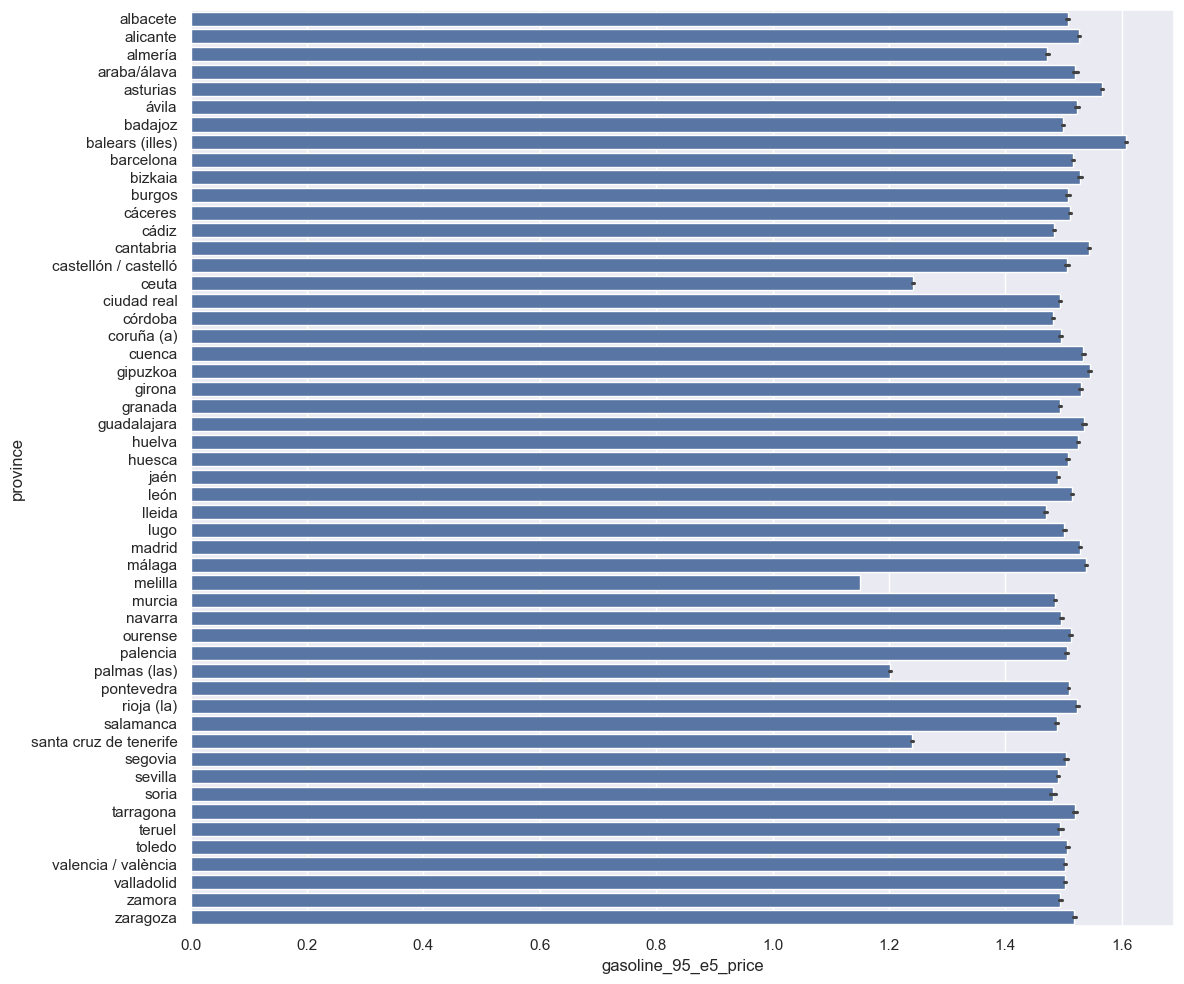

In [16]:
sns.barplot(data=pd_fuel_df, x="gasoline_95_e5_price", y="province", orient="h")
plt.tight_layout()

## Madrid gasoline_95_e5_price per Municipality

In [17]:
top_10_cheapest_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values()
    [:10]
)

In [18]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    .iloc[top_10_cheapest_mean_gas_price.index, :]
)

municipality gasoline_95_e5_price                             \
                                             count      mean       std    min   
87          torrejón de ardoz                669.0  1.389988  0.107640  1.249   
65                      parla                350.0  1.419417  0.111399  1.275   
61              navas del rey                 50.0  1.419700  0.044756  1.349   
92       torres de la alameda                 75.0  1.431267  0.091644  1.325   
55        moraleja de enmedio                 75.0  1.433933  0.082877  1.339   
10      becerril de la sierra                 25.0  1.436600  0.012189  1.421   
95                  valdemoro                373.0  1.444252  0.083081  1.299   
33                fuenlabrada                625.0  1.453893  0.099531  1.339   
81  santa maría de la alameda                 25.0  1.467000  0.016783  1.435   
22               ciempozuelos                150.0  1.467820  0.092115  1.359   

                                
      25%    50%    75%    max  
87  1.309  1.339  1.498  1.649  
65  1.339  1.379  1.569  1.609  
61  1.389  1.419  1.459  1.479  
92  1.365  1.379  1.554  1.569  
55  1.369  1.389  1.529  1.559  
10  1.427  1.437  1.441  1.467  
95  1.359  1.449  1.529  1.549  
33  1.379  1.389  1.579  1.619  
81  1.465  1.475  1.475  1.495  
22  1.389  1.429  1.579  1.629

In [19]:
top_10_most_expensive_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values(ascending=False)
    [:10]
)

In [20]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    .iloc[top_10_most_expensive_mean_gas_price.index, :]
)

municipality gasoline_95_e5_price                             \
                                         count      mean       std    min   
84             somosierra                 25.0  1.650720  0.009365  1.637   
98              venturada                 25.0  1.649000  0.010408  1.619   
62           nuevo baztán                 25.0  1.637600  0.020017  1.602   
67      perales de tajuña                125.0  1.636632  0.017897  1.584   
59            navacerrada                 50.0  1.633960  0.006178  1.619   
57       morata de tajuña                 25.0  1.632000  0.000000  1.632   
39  guadalix de la sierra                 25.0  1.629000  0.013844  1.589   
85          soto del real                 50.0  1.621800  0.020106  1.579   
91           torrelodones                 50.0  1.621000  0.016288  1.589   
54             molar (el)                 50.0  1.619800  0.022117  1.599   

                                 
       25%    50%    75%    max  
84  1.6440  1.654  1.658  1.664  
98  1.6490  1.649  1.659  1.659  
62  1.6320  1.652  1.652  1.652  
67  1.6290  1.639  1.649  1.659  
59  1.6290  1.634  1.639  1.652  
57  1.6320  1.632  1.632  1.632  
39  1.6190  1.629  1.639  1.649  
85  1.6090  1.629  1.639  1.659  
91  1.6115  1.619  1.629  1.649  
54  1.5990  1.609  1.639  1.649

## Madrid gasoline_95_e5_price per Locality

In [21]:
top_10_cheapest_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values()
    [:10]
)

In [22]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    .iloc[top_10_cheapest_mean_gas_price.index, :]
)

locality gasoline_95_e5_price                      \
                                                count      mean       std   
13                    base aerea                 25.0  1.317800  0.012689   
19                  caballo (el)                 25.0  1.374600  0.010033   
108            valmor-rompecubas                 25.0  1.379480  0.008761   
71                  nieves (las)                 25.0  1.387400  0.003742   
98             torrejon de ardoz                644.0  1.392790  0.108721   
90   san martin de valdeiglesias                 25.0  1.415000  0.010408   
76                         parla                350.0  1.419417  0.111399   
70                 navas del rey                 50.0  1.419700  0.044756   
41                 frailes (los)                 25.0  1.425000  0.007638   
103         torres de la alameda                 75.0  1.431267  0.091644   

                                        
       min    25%    50%    75%    max  
13   1.299  1.309  1.319  1.329  1.329  
19   1.364  1.369  1.369  1.374  1.404  
108  1.359  1.379  1.379  1.388  1.388  
71   1.379  1.389  1.389  1.389  1.389  
98   1.249  1.309  1.349  1.499  1.649  
90   1.399  1.409  1.419  1.419  1.429  
76   1.275  1.339  1.379  1.569  1.609  
70   1.349  1.389  1.419  1.459  1.479  
41   1.409  1.419  1.429  1.429  1.439  
103  1.325  1.365  1.379  1.554  1.569

In [23]:
top_10_most_expensive_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values(ascending=False)
    [:10]
)

In [24]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    .iloc[top_10_most_expensive_mean_gas_price.index, :]
)

locality gasoline_95_e5_price                             \
                                          count      mean       std    min   
95              somosierra                 25.0  1.650720  0.009365  1.637   
110              venturada                 25.0  1.649000  0.010408  1.619   
72            nuevo baztan                 25.0  1.637600  0.020017  1.602   
78       perales de tajuña                125.0  1.636632  0.017897  1.584   
68             navacerrada                 50.0  1.633960  0.006178  1.619   
66        morata de tajuña                 25.0  1.632000  0.000000  1.632   
48   guadalix de la sierra                 25.0  1.629000  0.013844  1.589   
54                 loeches                 75.0  1.623000  0.037633  1.549   
96           soto del real                 50.0  1.621800  0.020106  1.579   
102           torrelodones                 50.0  1.621000  0.016288  1.589   

                                  
        25%    50%    75%    max  
95   1.6440  1.654  1.658  1.664  
110  1.6490  1.649  1.659  1.659  
72   1.6320  1.652  1.652  1.652  
78   1.6290  1.639  1.649  1.659  
68   1.6290  1.634  1.639  1.652  
66   1.6320  1.632  1.632  1.632  
48   1.6190  1.629  1.639  1.649  
54   1.5790  1.649  1.649  1.659  
96   1.6090  1.629  1.639  1.659  
102  1.6115  1.619  1.629  1.649

## Madrid gasoline_95_e5_price per Label

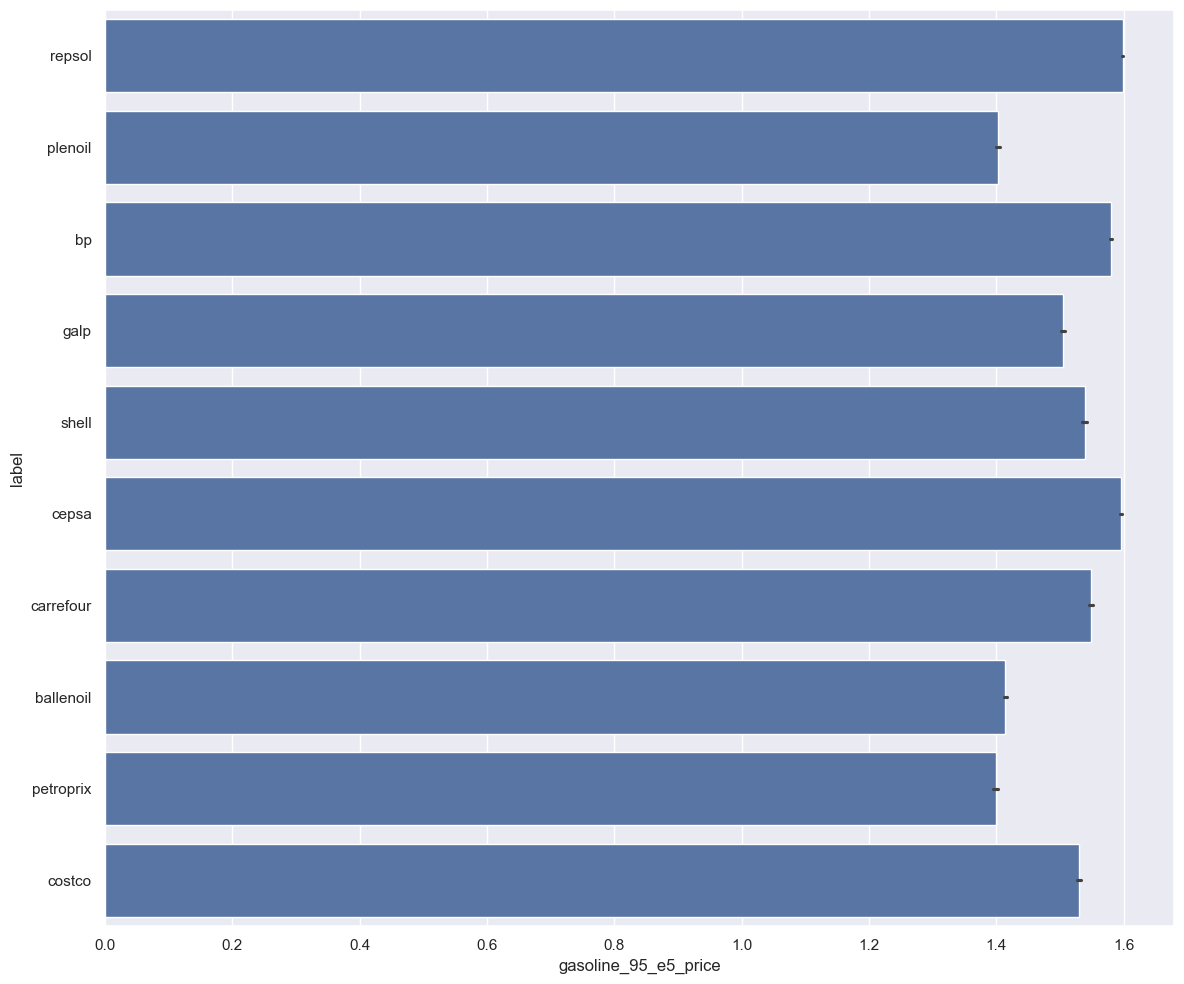

In [25]:
sns.barplot(
    data=pd_fuel_df.loc[(pd_fuel_df["province"] == "madrid")  & pd_fuel_df["label"].isin(label_list), ["label", "gasoline_95_e5_price"]],
    x="gasoline_95_e5_price",
    y="label",
    orient="h",
)
plt.tight_layout()

## Madrid gasoline_95_e5_price per ZipCode

In [26]:
(
    pd_fuel_df.loc[(pd_fuel_df["municipality"] == "madrid"), ["zip_code", "gasoline_95_e5_price"]]
    .groupby("zip_code").mean()
    .sort_values("gasoline_95_e5_price")
    .reset_index()
)

,zip_code,gasoline_95_e5_price
0,28000,1.441400
1,28021,1.454241
2,28038,1.459800
3,28044,1.474065
4,28054,1.486440
5,28041,1.491725
6,28031,1.496773
7,28052,1.501800
8,28032,1.502650
9,28022,1.510810


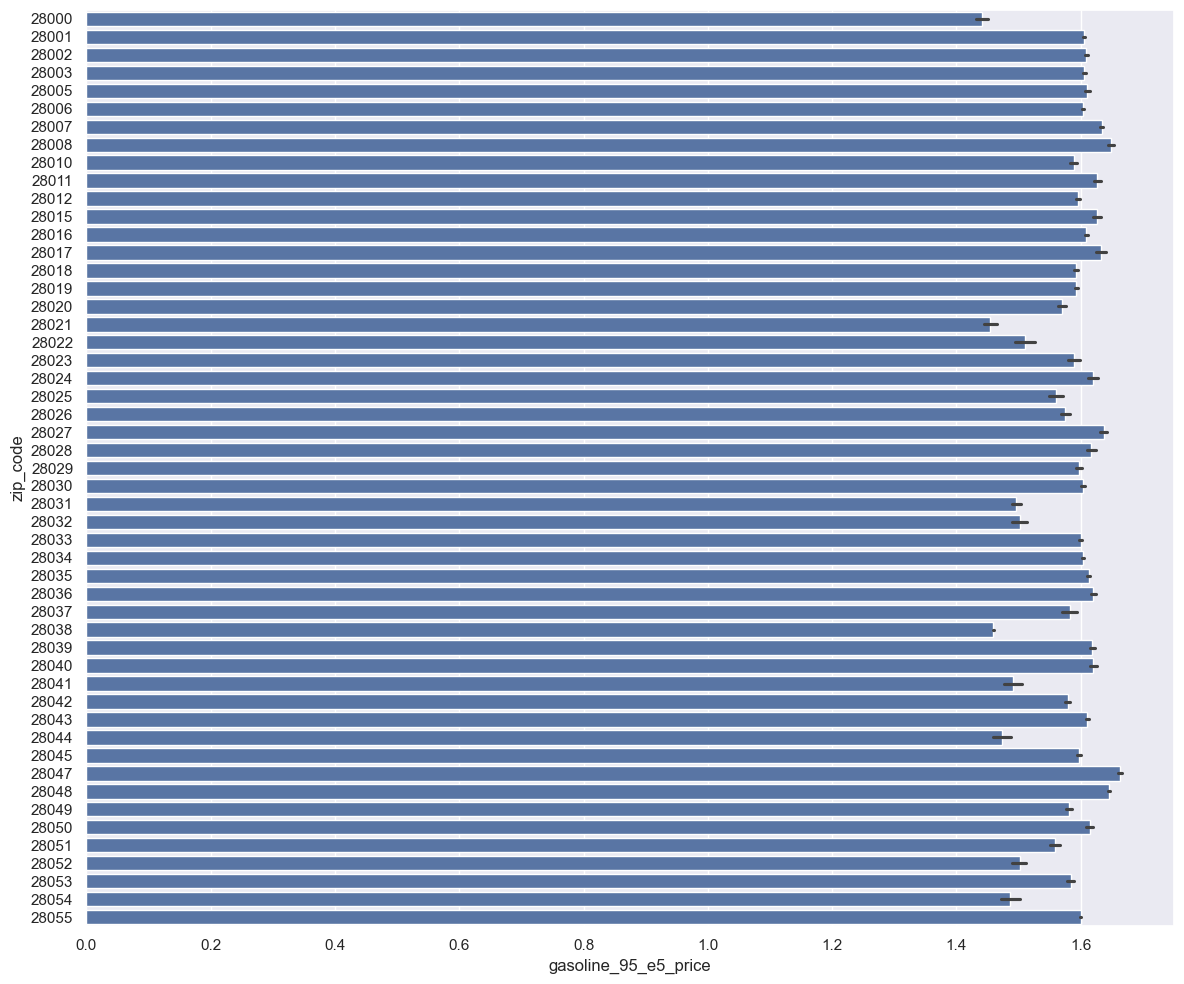

In [27]:
sns.barplot(
    data=pd_fuel_df.loc[(pd_fuel_df["municipality"] == "madrid"), ["zip_code", "gasoline_95_e5_price"]],
    x="gasoline_95_e5_price",
    y="zip_code",
    orient="h",
)
plt.tight_layout()

## Favorite EESS (Zip Code = 28050)

In [28]:
pd_fuel_df.loc[pd_fuel_df["zip_code"] == 28050, ["gasoline_95_e5_price", "gasoline_95_e5_premium_price", "gasoline_98_e5_price"]].describe()

,gasoline_95_e5_price,gasoline_95_e5_premium_price,gasoline_98_e5_price
count,75.000000,25.000000,75.000000
mean,1.614867,1.650840,1.759613
std,0.023290,0.008245,0.023960
min,1.589000,1.639000,1.729000
25%,1.599000,1.645000,1.744000
50%,1.609000,1.649000,1.755000
75%,1.629000,1.659000,1.759000
max,1.669000,1.659000,1.809000


In [29]:
unique_addresses = pd_fuel_df[(pd_fuel_df["zip_code"] == 28050) & pd_fuel_df["gasoline_95_e5_price"].notna()]["address"].unique()

mask = (
        (pd_fuel_df["zip_code"] == 28050) 
        & pd_fuel_df["timestamp"].notna() 
        & pd_fuel_df["gasoline_95_e5_price"].notna()
)

In [30]:
pd_fuel_df.loc[(pd_fuel_df["zip_code"] == 28050) & pd_fuel_df["gasoline_95_e5_price"].notna(), ["timestamp", "address", "gasoline_95_e5_price"]].groupby("address").describe()

gasoline_95_e5_price                            \
                                           count     mean       std    min   
address                                                                      
avenida manoteras, 34                       25.0  1.64340  0.015832  1.619   
calle abetal, 8                             25.0  1.60084  0.008245  1.589   
calle maria de portugal, 15                 25.0  1.60036  0.009036  1.589   

                                                         
                               25%    50%    75%    max  
address                                                  
avenida manoteras, 34        1.629  1.639  1.649  1.669  
calle abetal, 8              1.595  1.599  1.609  1.609  
calle maria de portugal, 15  1.594  1.603  1.605  1.622

In [31]:
pd_fuel_df[pd_fuel_df["province"] == "madrid"]["locality"].unique()

array(['ajalvir', 'alamo (el)', 'alcala de henares', 'alcobendas',
       'alcorcon', 'aldea del fresno', 'algete', 'alpedrete', 'aranjuez',
       'arganda', 'arroyomolinos', 'becerril de la sierra',
       'boadilla del monte', 'cerceda', 'brunete', 'buitrago del lozoya',
       'cabrera (la)', 'cadalso de los vidrios', 'campo real',
       'casarrubuelos', 'cenicientos', 'cercedilla', 'chinchon',
       'ciempozuelos', 'cobeña', 'collado mediano', 'collado villalba',
       'villalba de guadarrama', 'colmenar de oreja',
       'colmenar del arroyo', 'colmenar viejo', 'coslada',
       'daganzo de arriba', 'frailes (los)', 'escorial (el)', 'estremera',
       'fuenlabrada', 'fuente el saz de jarama', 'fuentidueña de tajo',
       'galapagar', 'getafe', 'aldehuela y la torrecilla (la)', 'griñon',
       'guadalix de la sierra', 'guadarrama', 'horcajo de la sierra',
       'hoyo de manzanares', 'humanes de madrid', 'leganes', 'butarque',
       'fortuna', 'loeches', 'caballo (el)', 'lo

In [32]:
sorted(pd_fuel_df[pd_fuel_df["zip_code"] == 28031]["locality"].unique())

['madrid']

In [33]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", ["timestamp", "zip_code", "sale_type", "label", "province", "municipality", "locality", "gasoline_95_e5_price"]
].groupby(["municipality", "label"])["gasoline_95_e5_price"].describe().head(50)

count      mean       std    min    25%  \
municipality      label                                                     
ajalvir           plenoil          25.0  1.421800  0.006137  1.419  1.419   
                  repsol           50.0  1.579200  0.008204  1.559  1.579   
alcalá de henares alcampo          25.0  1.399000  0.000000  1.399  1.399   
                  avia             25.0  1.425000  0.007638  1.409  1.419   
                  ballenoil        50.0  1.382000  0.007890  1.369  1.379   
                  bp               75.0  1.549533  0.058377  1.429  1.494   
                  carrefour        25.0  1.550200  0.006658  1.539  1.549   
                  cepsa            75.0  1.589253  0.020733  1.554  1.569   
                  energy           25.0  1.469000  0.000000  1.469  1.469   
                  galp            125.0  1.420080  0.043762  1.339  1.394   
                  gasexpress       25.0  1.375000  0.005000  1.369  1.369   
                  lavaplus         25.0  1.372600  0.008602  1.339  1.369   
                  petroprix        25.0  1.322200  0.036023  1.259  1.299   
                  plenoil          25.0  1.303800  0.028449  1.249  1.299   
                  repsol          125.0  1.580152  0.009629  1.549  1.575   
                  shell            75.0  1.481800  0.045667  1.418  1.419   
                  supeco           25.0  1.371400  0.013000  1.339  1.369   
alcobendas        alcampo          25.0  1.457000  0.010000  1.449  1.449   
                  ballenoil        50.0  1.454600  0.005014  1.449  1.449   
                  bp               75.0  1.593000  0.015596  1.569  1.579   
                  carrefour        25.0  1.566200  0.008426  1.549  1.559   
                  cepsa            50.0  1.613200  0.021569  1.569  1.594   
                  combus           25.0  1.463400  0.009165  1.449  1.449   
                  galp             75.0  1.537467  0.045441  1.469  1.509   
                  petroprix        50.0  1.454200  0.005047  1.449  1.449   
                  repsol          150.0  1.597560  0.014880  1.569  1.589   
                  scat             25.0  1.462800  0.012649  1.450  1.452   
                  shell            25.0  1.575720  0.013075  1.564  1.568   
alcorcón          alcampo          25.0  1.397000  0.014142  1.369  1.389   
                  aliara energía    0.0       NaN       NaN    NaN    NaN   
                  avia             50.0  1.481400  0.009806  1.459  1.479   
                  ballenoil        50.0  1.421600  0.019358  1.379  1.419   
                  bp              175.0  1.598600  0.008260  1.589  1.589   
                  cepsa            75.0  1.572907  0.038052  1.519  1.539   
                  lavaplus         25.0  1.361800  0.013077  1.339  1.369   
                  naturgy           0.0       NaN       NaN    NaN    NaN   
                  petroprix        25.0  1.418600  0.014855  1.379  1.419   
                  plenoil          75.0  1.423267  0.017256  1.379  1.419   
                  redexis           0.0       NaN       NaN    NaN    NaN   
                  repsol          125.0  1.603400  0.010112  1.579  1.599   
                  shell            75.0  1.482467  0.018417  1.459  1.469   
                  solner           25.0  1.468600  0.017436  1.439  1.469   
aldea del fresno  cepsa            25.0  1.574400  0.027710  1.544  1.554   
algete            ballenoil        25.0  1.468880  0.000332  1.468  1.469   
                  bp               25.0  1.545000  0.018484  1.509  1.539   
                  repsol           50.0  1.540420  0.012256  1.519  1.539   
                  shell            25.0  1.498840  0.000374  1.498  1.499   
alpedrete         cepsa            25.0  1.563560  0.015911  1.534  1.555   
                  petroprix        25.0  1.442320  0.012355  1.429  1.437   
                  plenoil          25.0  1.442520  0.012169  1.429  1.437   

                             

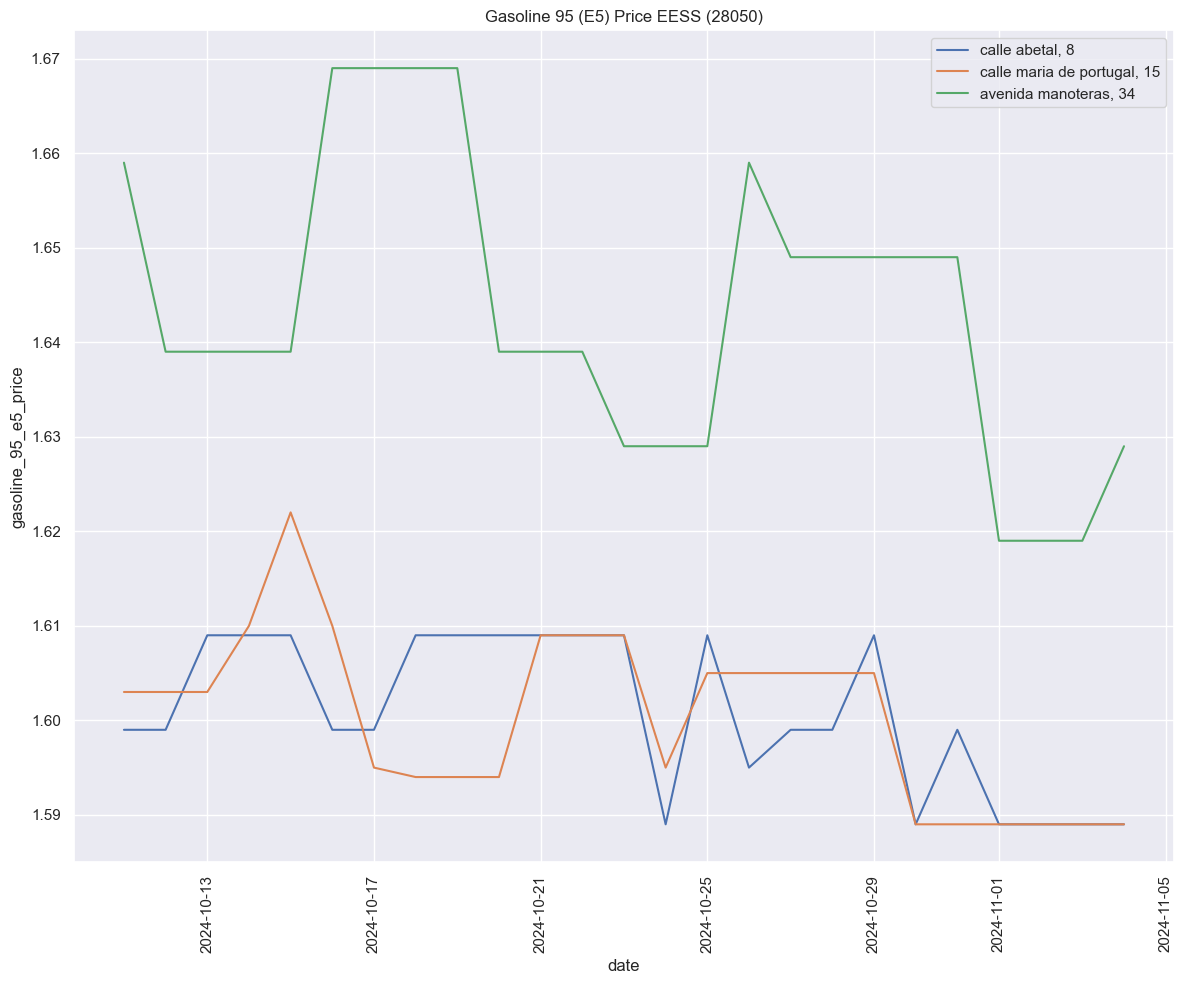

In [34]:
for address in unique_addresses:
    data_to_plot = pd_fuel_df.loc[mask & (pd_fuel_df["address"] == address), ["date", "address", "gasoline_95_e5_price"]]
    sns.lineplot(
        data=data_to_plot,
        x="date",
        y="gasoline_95_e5_price",
        label=address,
    )

plt.title("Gasoline 95 (E5) Price EESS (28050)")
plt.xticks(rotation=90)
plt.tight_layout()